# Cas de prédiction du Loto français 

In [1]:
#Import des librairies utiles
from bs4 import BeautifulSoup
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, TimeDistributed, RepeatVector, Flatten
from keras.callbacks import EarlyStopping

## Fonction de scraping des tirages

In [ ]:
def scrap_loto_numbers():
    my_list=[]
    time.sleep(2)
    loto_url = "http://loto.akroweb.fr/loto-historique-tirages/"
    page = requests.get(loto_url)
    soup = BeautifulSoup(page.text, 'html.parser')
    body = soup.find('table')
    tirage_line = body.find_all('tr')
    for value in tirage_line:
        my_dict = {}
        res = value.text.split('\n')
        my_dict['day']=res[2]
        my_dict['month_year']=res[3]

        for i,val in enumerate(res[5:10]):
            my_dict['num'+str(i)]=int(val)
        my_dict['chance']=int(res[10])
        my_list.append(my_dict)


    df=pd.DataFrame(my_list)
    return df

In [18]:
df_tirage=scrap_loto_numbers()
df_tirage[['day','month_year','num0','num1','num2','num3','num4','chance']].head()

df_tirage=df_tirage[(df_tirage['day']!='Vendredi') & (df_tirage['day']!='Mardi')]

## commentaires: 
* Nous retirons le dernier tirage à des fins de test
* Par contre, si nous voulons essayer de prédire le prochain tirage réel, alors nous ne devons pas le supprimer

**Nous devons donc executer soit l'une soit l'autre :**

***Test :***

In [19]:
df_tirage=df_tirage.tail(df_tirage.shape[0]-1)
df_tirage.head()

,day,month_year,num0,num1,num2,num3,num4,chance
1,Lundi,17 novembre 2025,7,17,26,28,45,6
2,Samedi,15 novembre 2025,5,11,22,23,24,3
3,Mercredi,12 novembre 2025,3,8,29,33,37,2
4,Lundi,10 novembre 2025,8,9,16,37,45,2
5,Samedi,08 novembre 2025,16,27,32,36,48,8


***Réel :***

In [ ]:
df_tirage=df_tirage.tail(df_tirage.shape[0])
df_tirage.head()

## Traitement  des données

On inverse le data frame pour les avoir dans l'ordre chronologique

In [22]:
df = df_tirage.iloc[::-1]
df = df[['num0', 'num1', 'num2', 'num3', 'num4', 'chance']]

In [23]:
df.tail()

,num0,num1,num2,num3,num4,chance
5,16,27,32,36,48,8
4,8,9,16,37,45,2
3,3,8,29,33,37,2
2,5,11,22,23,24,3
1,7,17,26,28,45,6


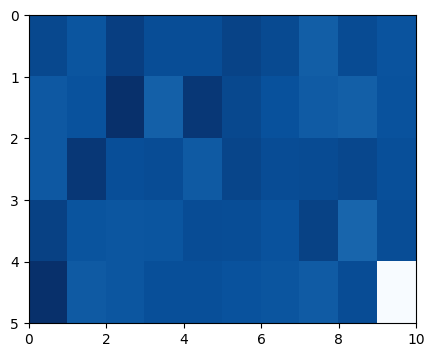

In [26]:
#fonction de vérification de nombres en dessous d'une certaine valeur pour les 5 premiers numéros, sauf celui de chance
def is_under(data, number):
    return ((data['num0'] <= number).astype(int) + 
            (data['num1'] <= number).astype(int) +
            (data['num2'] <= number).astype(int) +
            (data['num3'] <= number).astype(int) +
            (data['num4'] <= number).astype(int))

#fonction de vérification de nombres pairs pour les 5 premiers numéros sauf celui de chance
def is_pair(data):
    return ((data['num0'].isin(pairs)).astype(int) + 
            (data['num1'].isin(pairs)).astype(int) +
            (data['num2'].isin(pairs)).astype(int) +
            (data['num3'].isin(pairs)).astype(int) +
            (data['num4'].isin(pairs)).astype(int))

#fonction de vérification de nombres impairs pour les 5 premiers numéros sauf celui de chance
def is_impair(data):
    return ((data['num0'].isin(impairs)).astype(int) + 
            (data['num1'].isin(impairs)).astype(int) +
            (data['num2'].isin(impairs)).astype(int) +
            (data['num3'].isin(impairs)).astype(int) +
            (data['num4'].isin(impairs)).astype(int))

#fonction de vérification de nombres pairs pour le numéro de chance
def is_pair_etoile(data):
    return (data['chance'].isin(pairs)).astype(int)

#fonction de vérification de nombres impairs pour le numéro de chance
def is_impair_etoile(data):
    return (data['chance'].isin(impairs)).astype(int)

#liste de nombres pairs et impairs
pairs = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]
impairs = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]

#Fonction de calcul de la somme de la différence au carré des 5 premiers numéros, sauf celui de chance
def sum_diff(data):
    return ((data['num1'] - data['num0'])**2 + 
            (data['num2'] - data['num1'])**2 +
            (data['num3'] - data['num2'])**2 +
            (data['num4'] - data['num3'])**2)


# Calcul de la fréquence de tirage de chaque numéro
freqs = []
for val in range(50):
    count = ( (df['num0'] == val+1).sum() +
              (df['num1'] == val+1).sum() +
              (df['num2'] == val+1).sum() +
              (df['num3'] == val+1).sum() +
              (df['num4'] == val+1).sum() )
    freqs.append(count)
ax = plt.gca() ;  ax.invert_yaxis()
plt.gcf().set_size_inches(5, 4)
heatmap = plt.pcolor(np.reshape(np.array(freqs), (5, 10)), cmap=plt.cm.Blues)

def freq_val(data, column):
    tab = data[column].values.tolist()
    freqs = []
    pos = 1
    for e in tab:
        freqs.append(tab[0:pos].count(e))
        pos = pos + 1
    return freqs

In [ ]:
df['freq_num0'] = freq_val(df, 'num0')
df['freq_num1'] = freq_val(df, 'num1')
df['freq_num2'] = freq_val(df, 'num2')
df['freq_num3'] = freq_val(df, 'num3')
df['freq_num4'] = freq_val(df, 'num4')
df['freq_chance'] = freq_val(df, 'chance')
df['sum_diff'] = sum_diff(df)
df['pair_chance'] = is_pair_etoile(df)
df['impair_chance'] = is_impair_etoile(df)
df['pair'] = is_pair(df)
df['impair'] = is_impair(df)
df['is_under_24'] = is_under(df, 24)
df['is_under_40'] = is_under(df, 40)
df.head(6)

,num0,num1,num2,num3,num4,chance,sum,freq_num0,freq_num1,freq_num2,freq_num3,freq_num4,freq_chance,sum_diff,pair_chance,impair_chance,pair,impair,is_under_24,is_under_40
2747,19,24,27,33,41,9,0,1,1,1,1,1,1,134,0,1,1,4,2,4
2746,22,24,32,41,48,1,0,1,2,1,1,1,1,198,0,1,4,1,2,3
2745,10,20,22,39,46,4,0,1,1,1,1,1,1,442,1,0,4,1,3,4
2744,10,11,37,41,48,4,0,2,1,1,2,2,2,742,1,0,2,3,2,3
2743,18,20,28,40,49,1,0,1,2,1,1,1,2,293,0,1,4,1,2,4
2742,4,32,35,39,44,10,0,1,1,1,2,1,1,834,1,0,3,2,1,4


## Modèle et fonction de formatage des données en entrée du LSTM

In [30]:

nb_label_feature=6

UNITS = 100
BATCHSIZE = 30
EPOCH = 1500
OPTIMIZER ='adam'
LOSS = 'mae'
DROPOUT = 0.1
window_length =12
number_of_features = df.shape[1]

def define_model(number_of_features,nb_label_feature):
    model = Sequential()
    model.add(LSTM(UNITS, input_shape=(window_length, number_of_features), return_sequences=True))
    model.add(LSTM(UNITS, dropout=0.1, return_sequences=False))
    #ajout de la couche de sortie
    model.add(Dense(nb_label_feature))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model

def define_bidirectionnel_model(number_of_features,nb_label_feature):
    model = Sequential()
    model.add(Bidirectional(LSTM(100, dropout=0.2, return_sequences=True), input_shape=(window_length, number_of_features)))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(100, dropout=0.1))
    model.add(Dense(nb_label_feature))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model

def define_autoencoder_model(number_of_features,nb_label_feature):
    model = Sequential()
    model.add(LSTM(100, input_shape=(window_length, number_of_features), return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(RepeatVector(window_length))
    model.add(LSTM(100, dropout=0.1, return_sequences=True))
    model.add(LSTM(50, return_sequences=True))
    model.add(TimeDistributed(Dense(number_of_features)))
    model.add(Flatten())
    model.add(Dense(nb_label_feature))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model



#model = define_model(number_of_features,nb_label_feature)
#model3 = define_autoencoder_model(number_of_features,nb_label_feature)
#model4 = define_bidirectionnel_model(number_of_features,nb_label_feature)


es = EarlyStopping(monitor='acc', mode='max', verbose=1, patience=100)

In [31]:
def create_lstm_dataset(df, window_length,nb_label_feature):
    number_of_rows = df.shape[0]
    number_of_features = df.shape[1]
    scaler = StandardScaler().fit(df.values)
    transformed_dataset = scaler.transform(df.values)
    transformed_df = pd.DataFrame(data=transformed_dataset, index=df.index)
    train = np.empty([number_of_rows-window_length, window_length, number_of_features], dtype=float)
    
    label = np.empty([number_of_rows-window_length, nb_label_feature], dtype=float)
    for i in range(0, number_of_rows-window_length):
        train[i] = transformed_df.iloc[i:i+window_length, 0: number_of_features]
        label[i] = transformed_df.iloc[i+window_length: i+window_length+1, 0:nb_label_feature]
        
         
    model = define_model(number_of_features,nb_label_feature)
        
    return train, label, model,scaler

## Training

In [32]:
train, label,model,scaler1 = create_lstm_dataset(df, window_length,nb_label_feature)
print(train.shape)
print(label.shape)
 

(2674, 12, 20)
(2674, 6)


c:\Users\alecp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


* On voit ici que notre dataset d'entrainement après formatage est constitué de 1911 vecteurs contenant chacun 12 tirages où chaque tirage contient 19 features calculés plus haut

* Quant aux labels, on a bien 1911 vecteurs de 6 features soit les 6 numéros de chaque tirages

* Ainsi à partir des 12 tirages précédent on éssaie de prédire le tirage suivant lors de l'entrainement

In [33]:
history=model.fit(train, label, batch_size=BATCHSIZE, epochs=EPOCH, verbose=2, callbacks=[es])

Epoch 1/1500
90/90 - 2s - 21ms/step - acc: 0.1548 - loss: 0.8139
Epoch 2/1500
90/90 - 1s - 6ms/step - acc: 0.1548 - loss: 0.8085
Epoch 3/1500
90/90 - 0s - 5ms/step - acc: 0.1552 - loss: 0.8063
Epoch 4/1500
90/90 - 1s - 6ms/step - acc: 0.1634 - loss: 0.8045
Epoch 5/1500
90/90 - 0s - 6ms/step - acc: 0.1735 - loss: 0.8019
Epoch 6/1500
90/90 - 1s - 6ms/step - acc: 0.1623 - loss: 0.8005
Epoch 7/1500
90/90 - 0s - 6ms/step - acc: 0.1836 - loss: 0.7971
Epoch 8/1500
90/90 - 1s - 6ms/step - acc: 0.1900 - loss: 0.7938
Epoch 9/1500
90/90 - 0s - 5ms/step - acc: 0.2023 - loss: 0.7866
Epoch 10/1500
90/90 - 0s - 6ms/step - acc: 0.2004 - loss: 0.7797
Epoch 11/1500
90/90 - 0s - 5ms/step - acc: 0.2214 - loss: 0.7715
Epoch 12/1500
90/90 - 0s - 5ms/step - acc: 0.2248 - loss: 0.7634
Epoch 13/1500
90/90 - 0s - 5ms/step - acc: 0.2506 - loss: 0.7535
Epoch 14/1500
90/90 - 0s - 5ms/step - acc: 0.2506 - loss: 0.7370
Epoch 15/1500
90/90 - 0s - 5ms/step - acc: 0.2764 - loss: 0.7208
Epoch 16/1500
90/90 - 0s - 5ms/st

## Fonction de perte 

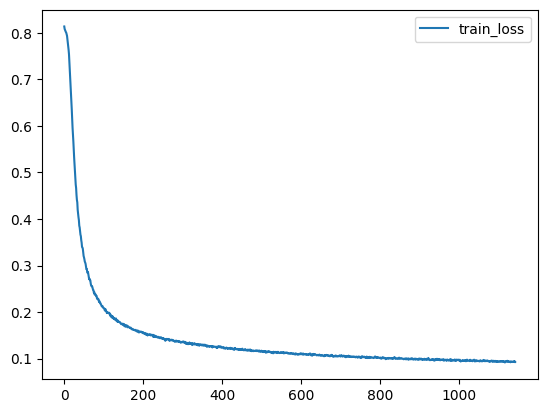

In [34]:
plt.plot(history.history['loss'])
plt.legend(['train_loss'])
plt.show()

## Résultats

In [35]:
last_twelve = df.tail(window_length)
scaler = StandardScaler().fit(df.values)
scaled_to_predict = scaler.transform(last_twelve)
scaled_predicted_output_1 = model.predict(np.array([scaled_to_predict]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


c:\Users\alecp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [ ]:
tom = df.tail(window_length).iloc[:,0:6] 
scaler = StandardScaler().fit(df.iloc[:,0:6])
scaled_to_predict = scaler.transform(tom)
print(scaler.inverse_transform(scaled_predicted_output_1).astype(int)[0])

[ 9 15 25 32 46  4]
